## **Классификация звонковых транзакций с использованием DecisionTreeClassifier**

---



**Обработка данных**

In [23]:
import pandas as pd
from datetime import datetime
from dateutil.parser import parse
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler, LabelEncoder, OneHotEncoder
from sklearn.tree import DecisionTreeClassifier 
from sklearn import metrics 
from matplotlib import pyplot as plt
from sklearn import tree
from sklearn.model_selection import GridSearchCV
import graphviz 
from sklearn.ensemble import VotingClassifier
import os

In [24]:
path = ''
samples_path = os.path.join(path, "data", "beeline_antispam_hakaton_id_samples.csv")
samples = pd.read_csv(samples_path)
samples.head()

,id,target,split
0,196535,NaN,test
1,63075900,2.0,train
2,35233935,2.0,train
3,23557360,4.0,train
4,78926486,NaN,test


In [25]:
samples.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46235 entries, 0 to 46234
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      46235 non-null  int64  
 1   target  36942 non-null  float64
 2   split   46235 non-null  object 
dtypes: float64(1), int64(1), object(1)
memory usage: 1.1+ MB


In [26]:
data_path = os.path.join(path, 'data', 'time_key=2021-11-01.csv')
data = pd.read_csv(data_path)
data.head()

,id_a,id_b,start_time_local,time_zone,duration,forward,zero_call_flg,source_b,source_f,num_b_length,time_key
0,67596082,43588153,18:43:03,3,0,0,3,0,1,10,2021-11-01
1,4024969,67656553,11:43:20,4,206,0,5,1,0,10,2021-11-01
2,43166780,31861625,10:32:36,0,5,0,0,0,1,10,2021-11-01
3,51817902,41201237,13:45:02,3,0,0,0,0,1,10,2021-11-01
4,41812796,4932754,13:53:12,0,0,0,5,0,1,10,2021-11-01


Выделим фичи из датасета и поделим их на числовые и категориальные.

In [27]:
num_cols = [
    'start_time_local',
    'duration',
    'num_b_length',
    'time_key'
]

cat_cols = [
    'time_zone',
    'forward',
    'zero_call_flg',
    'source_b',
    'source_f',
]

cols_withot_ids = num_cols +  cat_cols

<!--  -->
Посмотрим на пропущенные значения и уберем их при необходимости

In [28]:
data.isna().any()

id_a                False
id_b                False
start_time_local    False
time_zone           False
duration            False
forward             False
zero_call_flg       False
source_b            False
source_f            False
num_b_length        False
time_key            False
dtype: bool

In [29]:
data.fillna(inplace=True, method='ffill')

## **Preprocessing**
---

**Преобразуем время к числу**

In [30]:
# Время указано в секундах
data['start_time_local'] = pd.to_timedelta(data['start_time_local']).dt.total_seconds()

**Выделение нового признака из даты**

In [31]:
# Извлечем определенный день в месяце
data['time_key'] = pd.to_datetime(data['time_key'], errors='coerce').dt.day

## **Подготовка к обучению модели**
---

**Разделим данные на выборку для обучения и выборку для тестирования**

In [32]:
data = (
        data
        .merge(samples[['id','target', 'split']], left_on='id_a', right_on='id', how='inner') 
        .drop(columns=['id'])
)
# я пытался сделать через data.groupby(['split']), но в этой версии pandas возвращает tuple
data , data_predict = [x for _, x in data.groupby(data['split'] == 'test')]

# data , data_predict = [x for _, x in data.groupby(data['split'] == 'test')]
data = data.drop('split', axis=1)
data_predict = data_predict.drop('split', axis=1)

**Посмотрим на распределение целевой переменной**

In [33]:
data['target'].value_counts()

4.0    1338499
2.0      78479
0.0      67396
3.0      67165
1.0      10747
Name: target, dtype: int64

<div class="alert alert-warning", style="border:solid coral 3px; padding: 20px">
    <font size="4", color="DimGrey"><b>⚠️ Комментарий ревьюера</b></font>
    <br><br>
    <font size="3", color="black">
        Исторически уже так сложилось, что матрица с признаками обозначается за X (заглавной), т.к. это матрица, а y (прописной), т.к. в базовых задачах - вектор. Кароче, X и y - устоявшиеся обозначения!
    </font>
    <br><br>
    <font size="3", color="black">
        Везде, где есть влияние случайности стоит фиксировать random_state.
    </font>
<div>

**Нормирование при помощи числовых признаков**

In [34]:
sc = StandardScaler()
numeric_data = pd.DataFrame(sc.fit_transform(data[num_cols]),columns=num_cols,index=data.index)

**Кодирование при помощи one-hot encoding**

In [35]:
categorial_data = data[cat_cols]
print('Форма датасета с категориальными признаками:')
print(' до кодирования - ', categorial_data.shape)
dummy_features = pd.get_dummies(data = categorial_data, columns = cat_cols)
print(' после кодирования - ', dummy_features.shape)

Форма датасета с категориальными признаками:
 до кодирования -  (1562286, 5)
 после кодирования -  (1562286, 26)


In [36]:
X = pd.concat([numeric_data, dummy_features], axis=1)
X.head()

,start_time_local,duration,num_b_length,time_key,time_zone_-1,time_zone_0,time_zone_1,time_zone_2,time_zone_3,time_zone_4,...,zero_call_flg_0,zero_call_flg_1,zero_call_flg_2,zero_call_flg_3,zero_call_flg_4,zero_call_flg_5,source_b_0,source_b_1,source_f_0,source_f_1
0,1.497957,-0.199497,-0.018763,0.0,0,0,0,0,1,0,...,0,0,0,1,0,0,1,0,0,1
1,0.886654,-0.199497,-0.018763,0.0,0,0,0,0,1,0,...,0,0,0,0,0,1,1,0,0,1
2,-0.759946,-0.199497,-0.018763,0.0,0,1,0,0,0,0,...,0,0,0,0,0,1,1,0,0,1
3,-0.684600,-0.199497,-0.018763,0.0,0,0,0,0,1,0,...,1,0,0,0,0,0,1,0,0,1
4,0.167163,-0.199497,-0.018763,0.0,0,1,0,0,0,0,...,0,0,0,0,0,1,0,1,1,0


In [37]:
# TODO: ещё здесь ты учишь модель на id. на одном дне это ещё может и сработать, но что делать с новыми абонентами?
y = data['target']
X = data.drop('target', axis=1)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
)

In [38]:
# Создание объекта дерева решений
clf = DecisionTreeClassifier()
clf = clf.fit(X_train[cols_withot_ids], y_train)
# Предсказание ответа для тестового набора данных
y_pred = clf.predict(X_test[cols_withot_ids])

**Оценка точности**

In [39]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.8393288057914984


**Найдем наилучшие параметры при помощи кросс-валидации**

In [40]:
clf_best = GridSearchCV(
    DecisionTreeClassifier(),
    param_grid = {
        'max_depth': range(3, 5),
        'min_samples_split': range(2, 4),
        'criterion': ['gini', 'entropy']
    },
    n_jobs=-1,  # ознначает, что будут использоваться все процессоры для параллельных вычислений
    verbose=3, # TODO: спросить, почему не переобучает
    
    refit = True
)
clf_best.fit(X_train[cols_withot_ids], y_train)
None  

Fitting 5 folds for each of 8 candidates, totalling 40 fits


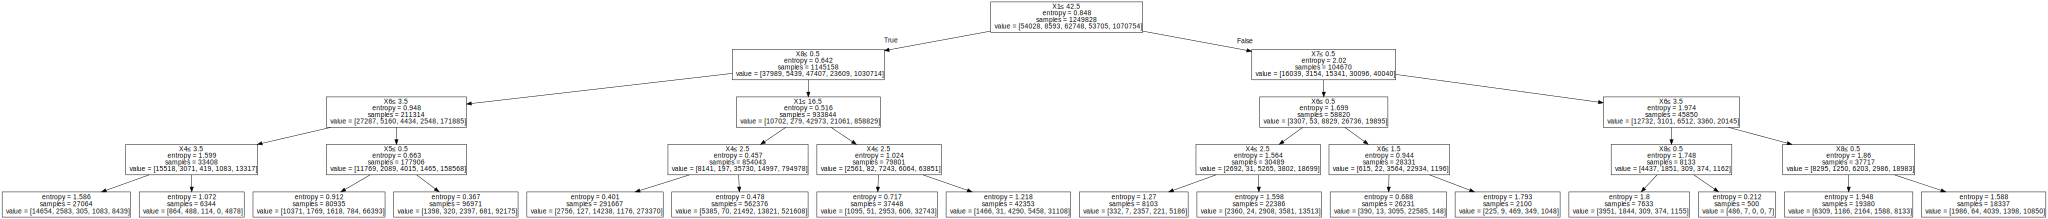

In [41]:
dot_data = tree.export_graphviz(clf_best.best_estimator_, out_file=None,  
                     special_characters=True)  
graph = graphviz.Source(dot_data)  
graph 

**Обучим модель с наилучшими параметрами и сравним её с прошлым вариантом модели**

In [42]:
y_pred_best = clf_best.predict(X_test[cols_withot_ids])
print("Accuracy:",metrics.accuracy_score(y_test, y_pred_best))

Accuracy: 0.8825474143724916


**Перейдем от классификации транзакций к классификации абонентов**

In [43]:
print(X_test.shape)
X_test['target'] = y_pred_best
print(X_test.shape)

(312458, 11)
(312458, 12)


In [44]:
dataIds = [x for _, x in X_test.groupby(data['id_a'])]
for i in dataIds:
  estimates = i['target'].value_counts()
  i['target'] = estimates.idxmax()

<div class="alert alert-warning", style="border:solid coral 3px; padding: 20px">
    <font size="4", color="DimGrey"><b>⚠️ Комментарий ревьюера</b></font>
    <br><br>
    <font size="3", color="black">
        Сейчас ты классифицируешь транзакции, а задача - классифицировать абонентов. Получается, что для одного абонента может быть несколько транзакций с разными предсказанными классами. Далее нужно на основе предсказаний транзакций сделать предсказание для абонента. Это можно сделать 2 способами: 1) жёсткое голосование (обычное), 2) мягкое голосование, то есть усредняются вероятности классов по всем транзакциям и выбирается класс с наибольшей вероятностью.
    </font>
<div>